<a href="https://colab.research.google.com/github/mrdostory/OpenSource_Project/blob/main/Toonify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Google drive 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install modules
!git clone https://github.com/mchong6/SOAT.git
%cd SOAT
!pip install tqdm gdown scikit-learn scipy lpips opencv-python kornia
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'SOAT'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 206 (delta 27), reused 26 (delta 26), pack-reused 176
Receiving objects: 100% (206/206), 71.16 MiB | 17.47 MiB/s, done.
Resolving deltas: 100% (64/64), done.
/content/SOAT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 551 kB 52.4 MB/s 
Cloning into 'models'...
remote: Enumerating objects: 3578, done.
remote: Counting objects: 100% (3578/3578), done.
remote: Compressing objects: 100% (2979/2979), done.
remote: Total 3578 (delta 942), reused 1512 (delta 545), pack-reused 0
Receiving objects: 100% (3578/3578), 47.07 MiB | 15.59 MiB/s, done.
Resolving deltas: 100% (942/942), done.


In [ ]:
# Install the Object Detection API (1 min)
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install -q .

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [ ]:
# import modules
import os
import torch
import numpy as np

import matplotlib.pyplot as plt
from model import Generator
from util import *

plt.rcParams['figure.dpi'] = 150

In [ ]:
# Generator
device = 'cuda' #@param ['cuda', 'cpu']

generator1 = Generator(256, 512, 8, channel_multiplier=2).eval().to(device)
generator2 = Generator(256, 512, 8, channel_multiplier=2).to(device).eval()

mean_latent1 = load_model(generator1, 'face.pt')
mean_latent2 = load_model(generator2, 'disney.pt')

print(len(mean_latent1))
print(mean_latent1[0].shape)

Downloading...
From: https://drive.google.com/uc?id=1dOBo4xWUwM7-BwHWZgp-kV1upaD6tHAh
To: /content/SOAT/face.pt
100%|██████████| 827M/827M [00:13<00:00, 60.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1n2uQ5s2XdUBGIcZA9Uabz1mkjVvKWFeG
To: /content/SOAT/disney.pt
100%|██████████| 812M/812M [00:12<00:00, 64.3MB/s]


20
torch.Size([1, 512])


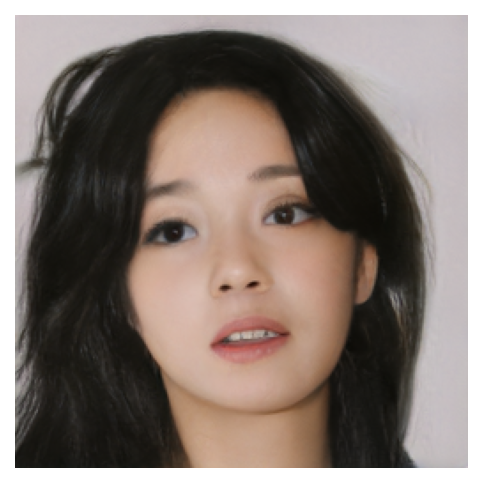

In [ ]:
latent_real = torch.load('/content/drive/MyDrive/OpenSW/KSJ.pt')['latent']
latent_real = style2list(latent_real)

source_im, _ = generator1(latent_real)

display_image(source_im)

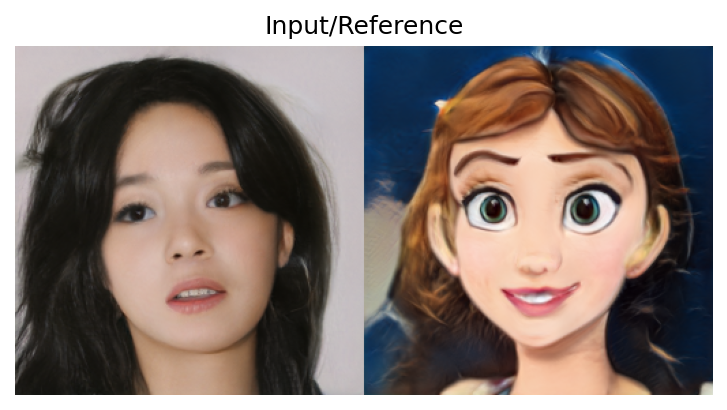

In [ ]:
truncation = .5
face_seed =  4454 #@param {type:"number"} 
disney_seed =  682548 #@param {type:"number"} 
    
with torch.no_grad():
    torch.manual_seed(face_seed)
    source_code = torch.randn([1, 512]).to(device)
    latent_real = torch.load('/content/drive/MyDrive/OpenSW/KSJ.pt')['latent']
    latent_real = style2list(latent_real)
    source_im, _ = generator1(latent_real)

    torch.manual_seed(disney_seed)
    reference_code = torch.randn([1, 512]).to(device)
    latent2 = generator2.get_latent(reference_code, truncation=truncation, mean_latent=mean_latent2)
    reference_im, _ = generator2(latent2)

    display_image(torch.cat([source_im, reference_im], -1), size=None, title='Input/Reference')

## Toonify input face using the reference disney face

- num_swap: determines how many early layers to borrow from input image. This controls how much structure to borrow from input image.
- alpha: controls the degree of toonification.

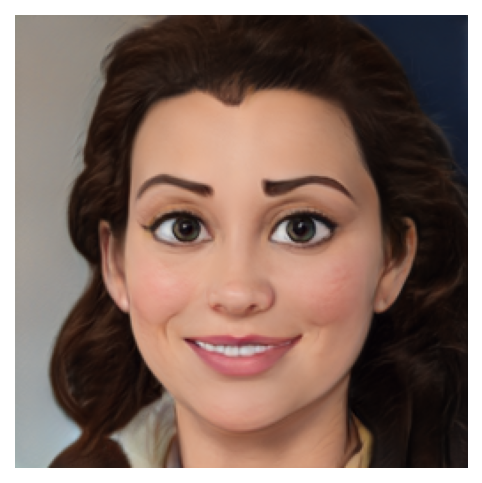

In [ ]:
num_swap =  6
alpha =  0.5

early_alpha = 0

def toonify(latent1, latent2):
    with torch.no_grad():
        noise1 = [getattr(generator1.noises, f'noise_{i}') for i in range(generator1.num_layers)]
        noise2 = [getattr(generator2.noises, f'noise_{i}') for i in range(generator2.num_layers)]

        out1 = generator1.input(latent1[0])
        out2 = generator2.input(latent2[0])
        out = (1-early_alpha)*out1 + early_alpha*out2

        out1, _ = generator1.conv1(out, latent1[0], noise=noise1[0])
        out2, _ = generator2.conv1(out, latent2[0], noise=noise2[0])
        out = (1-early_alpha)*out1 + early_alpha*out2

        skip1 = generator1.to_rgb1(out, latent1[1])
        skip2 = generator2.to_rgb1(out, latent2[1])
        skip = (1-early_alpha)*skip1 + early_alpha*skip2

        i = 2
        for conv1_1, conv1_2, noise1_1, noise1_2, to_rgb1, conv2_1, conv2_2, noise2_1, noise2_2, to_rgb2 in zip(
            generator1.convs[::2], generator1.convs[1::2], noise1[1::2], noise1[2::2], generator1.to_rgbs,
            generator2.convs[::2], generator2.convs[1::2], noise2[1::2], noise2[2::2], generator2.to_rgbs
        ):


            conv_alpha = early_alpha if i < num_swap else alpha
            out1, _ = conv1_1(out, latent1[i], noise=noise1_1)
            out2, _ = conv2_1(out, latent2[i], noise=noise2_1)
            out = (1-conv_alpha)*out1 + conv_alpha*out2
            i += 1

            conv_alpha = early_alpha if i < num_swap else alpha
            out1, _ = conv1_2(out, latent1[i], noise=noise1_2)
            out2, _ = conv2_2(out, latent2[i], noise=noise2_2)
            out = (1-conv_alpha)*out1 + conv_alpha*out2
            i += 1

            conv_alpha = early_alpha if i < num_swap else alpha
            skip1 = to_rgb1(out, latent1[i], skip)
            skip2 = to_rgb2(out, latent2[i], skip)
            skip = (1-conv_alpha)*skip1 + conv_alpha*skip2

            i += 1

    image = skip.clamp(-1,1)
    
    return image

result = toonify(latent1, latent2)
display_image(result)

## Real World Image

- https://mobile.newsis.com/view.html?ar_id=NISX20211028_0001631529

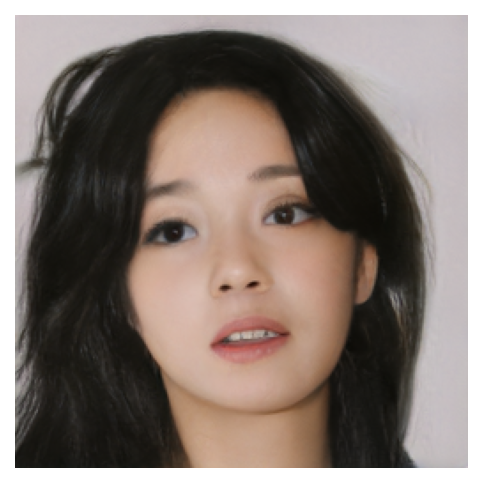

In [ ]:
latent_real = torch.load('/content/drive/MyDrive/OpenSW/KSJ.pt')['latent']
latent_real = style2list(latent_real)

source_im, _ = generator1(latent_real)

display_image(source_im)

In [ ]:
from PIL import Image

Image.open('imgs/01.jpg')

FileNotFoundError: ignored

In [ ]:
result2 = toonify(latent_real, latent2)

display_image(result2)